In [67]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, kstest, norm, t
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
import os
os.chdir("/Users/kakifang/Documents/duke/fintech540/FinTech545_Spring2025/Projects/Project02")


In [89]:
#1 A B
#load data
data = pd.read_csv("DailyPrices.csv", parse_dates=['Date'])

#select stock
stocks = ['SPY', 'AAPL', 'EQIX']
prices = data[stocks].copy()

#Arithmetic return
arith_returns = prices.pct_change().dropna()

# remove mean and calculate sd
arith_returns_demeaned = arith_returns - arith_returns.mean()
std_arith = arith_returns_demeaned.std()

#display
print("Arithmetic Returns (Last 5 rows):")
print(arith_returns_demeaned.tail())
print("\nArithmetic Returns Standard Deviations:")
print(std_arith)
print("total log sd", sum(std_arith))

#log
log_returns = np.log(prices / prices.shift(1)).dropna()

# remove mean and calculate sd
log_returns_demeaned = log_returns - log_returns.mean()
std_log = log_returns_demeaned.std()

# display
print("\nLog Returns (Last 5 rows):")
print(log_returns_demeaned.tail())
print("\nLog Returns Standard Deviations:")
print(std_log)
print("total log sd", sum(std_log))

Arithmetic Returns (Last 5 rows):
          SPY      AAPL      EQIX
499 -0.011492 -0.014678 -0.006966
500 -0.012377 -0.014699 -0.008064
501 -0.004603 -0.008493  0.006512
502 -0.003422 -0.027671  0.000497
503  0.011538 -0.003445  0.015745

Arithmetic Returns Standard Deviations:
SPY     0.008077
AAPL    0.013483
EQIX    0.015361
dtype: float64
total log sd 0.03692020042548768

Log Returns (Last 5 rows):
          SPY      AAPL      EQIX
499 -0.011515 -0.014675 -0.006867
500 -0.012410 -0.014696 -0.007972
501 -0.004577 -0.008427  0.006602
502 -0.003392 -0.027930  0.000613
503  0.011494 -0.003356  0.015725

Log Returns Standard Deviations:
SPY     0.008078
AAPL    0.013446
EQIX    0.015270
dtype: float64
total log sd 0.036794890604909536


In [69]:
#2 A
#load data sort by price
data = pd.read_csv("DailyPrices.csv", parse_dates=["Date"])
data.sort_values("Date", inplace=True)

#position
portfolio = {"SPY": 100.0, "AAPL": 200.0, "EQIX": 150.0}
target_date = "2025-01-03"

#calculate value
row = data[data["Date"] == target_date]
total_value = 0.0
for stock in portfolio:
    price = float(row[stock].iloc[0])
    total_value += portfolio[stock] * price

print("Portfolio Value on", target_date, "=", f"${total_value:,.2f}")


Portfolio Value on 2025-01-03 = $251,862.50


In [90]:
# 2 B a
# Exponential weighted covariance calculation
def calc_exp_cov(data, decay=0.97):
    weights = np.array([decay ** i for i in range(len(data))])[::-1]
    weights /= weights.sum()
    avg = np.average(data, axis=0, weights=weights)
    diff = data - avg
    cov_matrix = np.dot(weights * diff.T, diff)
    return pd.DataFrame(cov_matrix, index=data.columns, columns=data.columns)

#filter data and compute return
stocks = list(portfolio.keys())
sub_prices = data[["Date"] + stocks].dropna().sort_values("Date").set_index("Date")
daily_ret = sub_prices.pct_change().dropna()

# demean value
ret_zero = daily_ret - daily_ret.mean()
exp_cov = calc_exp_cov(ret_zero, decay=0.97).values
z_score = norm.ppf(0.05)
pdf_val = norm.pdf(z_score)

# weights in dollars
assets = np.array([portfolio[s] * curr_prices[s] for s in stocks])
dollar_w = assets / port_value


p_var = dollar_w @ exp_cov @ dollar_w
p_std = np.sqrt(p_var)
var_norm = -z_score * p_std * port_value
es_norm = p_std * (pdf_val / 0.05) * port_value

print("Normal VaR:", var_norm)
print("Normal ES:", es_norm)


Normal VaR: 3856.3183014814767
Normal ES: 4835.978727805546


In [91]:
# 2B b
import numpy as np
import pandas as pd
from scipy.stats import norm, t, multivariate_normal

def simulate_tcopula(csv_path, tickers, positions, alpha=0.05):
    df_all = pd.read_csv(csv_path, parse_dates=["Date"])
    df_all.sort_values("Date", inplace=True, ignore_index=True)

    df_returns = df_all.copy()
    for sym in tickers:
        df_returns[sym] = df_returns[sym].pct_change()
    df_returns.dropna(inplace=True)
    ret_zero = {}
    t_params = {}
    for sym in tickers:
        vals = df_returns[sym].values
        centered = vals - np.mean(vals)
        ret_zero[sym] = centered
        df_val, loc_val, scale_val = t.fit(centered, method="MLE")
        t_params[sym] = (df_val, loc_val, scale_val)
    
    U = pd.DataFrame({sym: t.cdf(ret_zero[sym], *t_params[sym]) for sym in tickers})

    norm_q = U.apply(lambda col: norm.ppf(col))
    spearman_corr = norm_q.corr(method="spearman")
    
    np.random.seed(29)
    sim_norm = multivariate_normal.rvs(
        mean=np.zeros(len(tickers)),
        cov=spearman_corr,
        size=n_sim
    )
    
    sim_t = np.zeros_like(sim_norm)
    for i, sym in enumerate(tickers):
        df_val, loc_val, scale_val = t_params[sym]
        u_sim = norm.cdf(sim_norm[:, i])
        sim_t[:, i] = t.ppf(u_sim, df_val, loc_val, scale_val)
    
    last_prices = df_all.iloc[-1]
    sim_pnl = np.zeros(n_sim)
    for i, sym in enumerate(tickers):
        sim_pnl += positions[sym] * last_prices[sym] * sim_t[:, i]
    
    var_val = np.percentile(sim_pnl, alpha * 100)
    es_val = sim_pnl[sim_pnl <= var_val].mean() if np.any(sim_pnl <= var_val) else var_val
    total_value = sum(positions[sym] * last_prices[sym] for sym in tickers)
    
    return var_val, es_val, sim_pnl, total_value

csv_file = "DailyPrices.csv"
stock_list = ["SPY", "AAPL", "EQIX"]
pos_dict = {"SPY": 100.0, "AAPL": 200.0, "EQIX": 150.0}
alpha_level = 0.05

var_sim, es_sim, sim_results, port_val = simulate_tcopula(csv_file, stock_list, pos_dict, alpha=alpha_level)

print(f"Portfolio Value: ${port_val:,.2f}")
print(f"{int(alpha_level*100)}% VaR = ${-var_sim:,.2f}")
print(f"{int(alpha_level*100)}% ES  = ${-es_sim:,.2f}")


Portfolio Value: $251,862.50
5% VaR = $4,369.76
5% ES  = $6,074.73


In [92]:
#2 b c Historical var
hist_pnl = ret_zero.values @ np.array([positions[s] * curr_prices[s] for s in stocks])
var_hist = np.percentile(hist_pnl, 5)
es_hist = hist_pnl[hist_pnl <= var_hist].mean() if np.any(hist_pnl <= var_hist) else var_hist
print(f"Historical 5% VaR: ${-var_hist:,.2f}")
print(f"Historical 5% ES: ${-es_hist:,.2f}")


Historical 5% VaR: $4,575.03
Historical 5% ES: $6,059.39


In [76]:
#question 3 A
import math
from math import log, sqrt, exp
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np
import matplotlib.pyplot as plt

#bsm
def bs_call(spot, strike, time, rate, vol):
    d1 = (log(spot / strike) + (rate + 0.5 * vol**2) * time) / (vol * sqrt(time))
    d2 = d1 - vol * sqrt(time)
    return spot * norm.cdf(d1) - strike * exp(-rate * time) * norm.cdf(d2)

def bs_put(spot, strike, time, rate, vol):
    d1 = (log(spot / strike) + (rate + 0.5 * vol**2) * time) / (vol * sqrt(time))
    d2 = d1 - vol * sqrt(time)
    return strike * exp(-rate * time) * norm.cdf(-d2) - spot * norm.cdf(-d1)

def iv_call(spot, strike, time, rate, market):
    f = lambda vol: bs_call(spot, strike, time, rate, vol) - market
    return brentq(f, 1e-6, 5.0)


# Base parameters
spot = 31.0
strike = 30.0
rate = 0.10
maturity = 0.25
mkt_call = 3.0

iv = iv_call(spot, strike, maturity, rate, mkt_call)
print(f"IV = {iv*100:.2f}%")

IV = 33.51%


In [84]:
# 3 B Option Greeks
def delta_call(spot, strike, time, rate, vol):
    d1 = (log(spot / strike) + (rate + 0.5 * vol**2) * time) / (vol * sqrt(time))
    return norm.cdf(d1)

def delta_put(spot, strike, time, rate, vol):
    return delta_call(spot, strike, time, rate, vol) - 1

def vega_call(spot, strike, time, rate, vol):
    d1 = (log(spot / strike) + (rate + 0.5 * vol**2) * time) / (vol * sqrt(time))
    return spot * norm.pdf(d1) * sqrt(time)

def theta_call(spot, strike, time, rate, vol):
    d1 = (log(spot / strike) + (rate + 0.5 * vol**2) * time) / (vol * sqrt(time))
    d2 = d1 - vol * sqrt(time)
    return - (spot * norm.pdf(d1) * vol) / (2 * sqrt(time)) - rate * strike * exp(-rate * time) * norm.cdf(d2)

def theta_put(spot, strike, time, rate, vol):
    d1 = (log(spot / strike) + (rate + 0.5 * vol**2) * time) / (vol * sqrt(time))
    d2 = d1 - vol * sqrt(time)
    return - (spot * norm.pdf(d1) * vol) / (2 * sqrt(time)) + rate * strike * exp(-rate * time) * norm.cdf(-d2)


d_c = delta_call(spot, strike, maturity, rate, iv)
v_c = vega_call(spot, strike, maturity, rate, iv)
t_c = theta_call(spot, strike, maturity, rate, iv)
d_p = delta_put(spot, strike, maturity, rate, iv)
t_p = theta_put(spot, strike, maturity, rate, iv)
print(f"Call Delta = {d_c:.4f}")
print(f"Put Delta = {d_p:.4f}")
print(f"Call Vega  = {v_c:.4f}")
print(f"Call Theta = {t_c:.4f}")
print(f"Put Theta = {t_p:.4f}")

# Vega approximation
iv_adj = iv + 0.01
price0 = bs_call(spot, strike, maturity, rate, iv)
price1 = bs_call(spot, strike, maturity, rate, iv_adj)
print(f"Actual Price Change = {price1 - price0:.4f}")
print(f"Vega Approx Change = {v_c * 0.01:.4f}")



Call Delta = 0.6659
Put Delta = -0.3341
Call Vega  = 5.6407
Call Theta = -5.5446
Put Theta = -2.6186
Actual Price Change = 0.0565
Vega Approx Change = 0.0564


In [85]:
# 3 C Put price and put-call parity check
put_val = bs_put(spot, strike, maturity, rate, iv)
lhs = mkt_call + strike * exp(-rate * maturity)
rhs = put_val + spot
print(f"Put Price = {put_val:.4f}")
print(f"LHS (Call + PV) = {lhs:.4f}")
print(f"RHS (Put + Spot)= {rhs:.4f}")
print(f"Difference = {lhs - rhs:.8f}")

Put Price = 1.2593
LHS (Call + PV) = 32.2593
RHS (Put + Spot)= 32.2593
Difference = 0.00000000


In [98]:
# 3 D
days_year = 255
hold_days = 20
ann_vol = 0.25
daily_vol = ann_vol / math.sqrt(days_year)
vol_20d = daily_vol * sqrt(hold_days)

call0 = bs_call(spot, strike, maturity, rate, iv)
put0 = bs_put(spot, strike, maturity, rate, iv)
port0 = call0 + put0 + spot
print("Portfolio Info:")
print(f"Stock = {spot:.2f}, Call = {call0:.4f}, Put = {put0:.4f}, Total = {port0:.4f}")

# Compute portfolio Greeks
d_call_val = delta_call(spot, strike, maturity, rate, iv)
d_put_val  = delta_put(spot, strike, maturity, rate, iv)
port_delta = d_call_val + d_put_val + 1.0
theta_val_call = theta_call(spot, strike, maturity, rate, iv)
theta_val_put = theta_put(spot, strike, maturity, rate, iv)
port_theta = theta_val_call + theta_val_put
dt = hold_days / days_year
mean_pnl = port_theta * dt
std_pnl = abs(port_delta) * spot * vol_20d
z = norm.ppf(0.05)
var_dn = -(mean_pnl + z * std_pnl)
phi = norm.pdf(z)
es_dn = std_pnl * phi / 0.05 - mean_pnl

print("\nDelta-Normal Approximation:")
print(f"Delta = {port_delta:.4f}, Theta = {port_theta:.4f}")
print(f"Mean PnL = {mean_pnl:.4f}, Std PnL = {std_pnl:.4f}")
print(f"VaR (95%) = {var_dn:.4f}, ES (95%) = {es_dn:.4f}")

# Monte Carlo simulation
n_sim = 100000
np.random.seed(29)
rand_draws = np.random.normal(0, vol_20d, n_sim)
spot_sim = spot * np.exp(rand_draws)
time_new = maturity - (hold_days / days_year)
call_sim = np.array([bs_call(s, strike, time_new, rate, iv) for s in spot_sim])
put_sim  = np.array([bs_put(s, strike, time_new, rate, iv) for s in spot_sim])
port_sim = call_sim + put_sim + spot_sim
pnl = port_sim - port0
sorted_pnl = np.sort(pnl)
var_mc = -sorted_pnl[int(0.05 * n_sim)]
es_mc = -sorted_pnl[:int(0.05 * n_sim)].mean()

print("\nMonte Carlo Simulation:")
print(f"Sims = {n_sim}, Mean PnL = {pnl.mean():.4f}")
print(f"VaR (95%) = {var_mc:.4f}, ES (95%) = {es_mc:.4f}")


Portfolio Info:
Stock = 31.00, Call = 3.0000, Put = 1.2593, Total = 35.2593

Delta-Normal Approximation:
Delta = 1.3319, Theta = -8.1632
Mean PnL = -0.6403, Std PnL = 2.8907
VaR (95%) = 5.3951, ES (95%) = 6.6030

Monte Carlo Simulation:
Sims = 100000, Mean PnL = -0.2083
VaR (95%) = 4.1383, ES (95%) = 4.5823


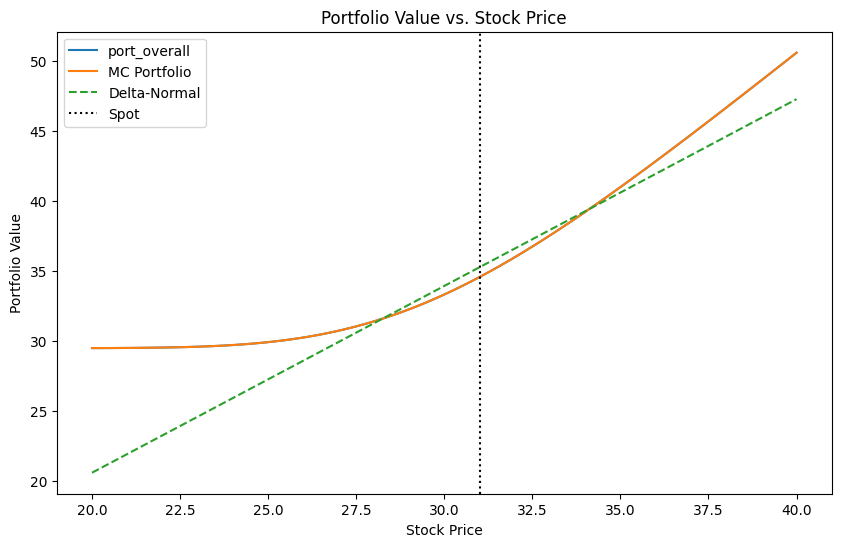

In [88]:
# 3 E
spot_range = np.linspace(20, 40, 100)
call_vals = np.array([bs_call(s, strike, time_new, rate, iv) for s in spot_range])
put_vals  = np.array([bs_put(s, strike, time_new, rate, iv) for s in spot_range])
port_overall = call_vals + put_vals + spot_range
port_val_mc = call_vals + put_vals + spot_range
port_val_dn = port0 + port_delta * (spot_range - spot)

plt.figure(figsize=(10, 6))
plt.plot(spot_range, port_overall, label="port_overall")
plt.plot(spot_range, port_val_mc, label="MC Portfolio")
plt.plot(spot_range, port_val_dn, '--', label="Delta-Normal")
plt.axvline(x=spot, color='black', linestyle=':', label="Spot")
plt.xlabel("Stock Price")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value vs. Stock Price")
plt.legend()
plt.show()